# Build your own optimized local pseudopotential (LPP)

In this tutorial you will be able to build you own LPP for Au.

- Run a KS calculation to get the electronic density using [QEpy](http://qepy.rutgers.edu/)
- Perform a OF calculation to optimize $v_{LPP}(\mathbf{r})$
- Test the generated LPP by comparing against the phonon spectra from [EMT](https://wiki.fysik.dtu.dk/ase/ase/phonons.html#module-ase.phonons) from [ASE](https://wiki.fysik.dtu.dk/ase/)

# QEpy 

First we need to generate the target electron density using QEpy, for that we will need to load the following modules

In [1]:
import numpy as np
from qepy.io import QEInput
from qepy.driver import Driver

The following step is to build the crystal structure of FCC Au with ASE (feel free to use other phases)

In [2]:
from ase.build import bulk
atoms = bulk('Au', 'fcc', a=4.078)

Once the structure is built we set up the necessary options to instance the QEpy driver (refer to QE pw.x for details) and perform a scf calculation 

In [3]:
qe_options = {
    '&control': {
        'calculation': "'scf'",
        'prefix': "'tmp'",
        'pseudo_dir': "'../DATA'"},
    '&system': {
        'ibrav' : 0,
        'degauss': 0.01,
        'ecutwfc': 50,
        'ecutrho': 300,
        'occupations': "'smearing'"
    },
    '&electrons': {
        'conv_thr' : 1.0e-8},
     'atomic_species': ['Au 196.96657 au_lda_v1.uspp.F.UPF'],
     'k_points automatic': ['11 11 11 0 0 0'],
}

In [4]:
driver = Driver(qe_options=qe_options, atoms=atoms, logfile='tmp.out')

In [5]:
driver.calc_energy()

-132.2817713943313

### Collect the electron density for comparison

 - First retrieve the Quantum ESPRESSO density as a Fortran-ordered numpy array.
 - Then transform it into a DFTpy `DirectField` which is a class to handle real-space grid functions.
 - Write the density onto a `snpy` or `xsf` file.

In [6]:
density = driver.get_density()

In [7]:
rho_ks = driver.data2field(density)
ions = driver.get_dftpy_ions()
rho_ks.write('../DATA/rho_target.xsf', ions=ions)

# DFTpy: optimize the LPP

In this section we will build a smooth Local pseudopotential with DFTpy modules

In [8]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ
from scipy.optimize import minimize

We load the same PP as the KS calculation. We will optimize the LPP to reproduce the KS density

In [9]:
ions, rho_target, _ = io.read_all('../DATA/rho_target.xsf')
grid = rho_target.grid
PP_list = {'Au': '../DATA/au_lda_v1.uspp.F.UPF'}

In [10]:
MaxPoints=1000 # number of points in the one-dimensional PP function
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, MaxPoints=MaxPoints)
rho_ini = rho_target.copy()

setting key: Au -> ../DATA/au_lda_v1.uspp.F.UPF


### Load the needed density functionals
Here we use TF + 0.2 vW, however you can choose any functional. We find the LPPs from TF+0.2vW to be transferable for use with other functionals

In [11]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='LDA', libxc=False)
HARTREE = Functional(type='HARTREE')

### Define the total energy functional

In [12]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

### Optimize the electron density with DFTpy

In [13]:
optimization_options = {'econv' : 1e-6*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'TN')
rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -2.829202916983E+01     -2.829203E+01   1.071715E+01    1       1       1.508641E-02    
!WARN : pAp small than zero :iter =  2 -13869586.071581276
1       -3.026431867579E+01     -1.972290E+00   1.898336E+00    3       2       4.524398E-02    
2       -3.053032393062E+01     -2.660053E-01   1.792215E-01    9       1       9.649873E-02    
3       -3.054163434346E+01     -1.131041E-02   9.136675E-03    6       1       1.294124E-01    
4       -3.054206924089E+01     -4.348974E-04   7.360995E-04    7       1       1.677411E-01    
5       -3.054214000359E+01     -7.076270E-05   5.784101E-05    11      1       2.224207E-01    
6       -3.054214279047E+01     -2.786887E-06   3.930147E-06    8       1       2.638590E-01    
7       -3.054214313039E+01     -3.399122E-07   3.422536E-07    11      1       3.183517E-01    
8       -3.054214314688E+01     -1.649943E-08   1.956503E-08    8   

The density obtained is from the local part of the GBRV PP and thus it is far from the KS density

## LPP optimization

The delta_pp function is a polynomial which coefficients {a} are optimized to reproduce the KS electron density.

In [14]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

The following function represents the new tunable short range PP on the simulation grid

In [15]:
def lpp2vloc(r, v, ions, grid, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={'Au':engine}, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [16]:
grid = rho_target.grid
rcut = 2.35 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = np.zeros(3)

ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})

opt = Optimization(EnergyEvaluator=evaluator)

rho_ini = rho_target.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_target)).integral()
    # print('aa:', a, diff)
    return diff

Once callable functions are defined we can optimize

In [ ]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})
environ['LOGLEVEL'] = 2

In [17]:
a = res.x
key = 'Au'
r = PSEUDO.readpp.pp[key].r
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 79 # From GBRV PP
engine._zval = 11.0 # From GBRV PP

Visualize the Local pseudopotentials and the electron density

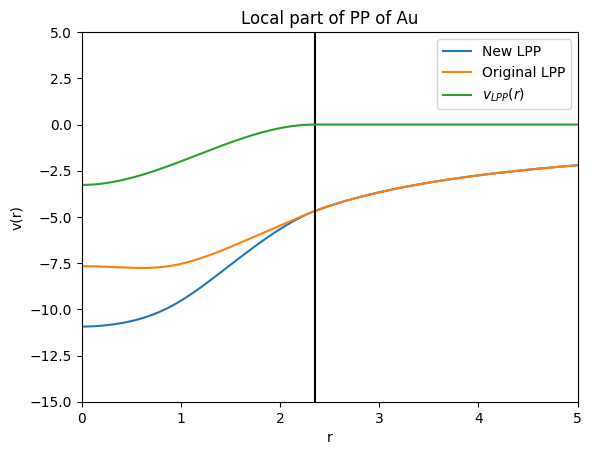

In [18]:
import matplotlib.pyplot as plt
plt.plot(r,v, label='New LPP')
plt.plot(r,vl, label='Original LPP')
rcut = rcut
r1=np.linspace(start=0.01,stop=20,num=1000)
plt.vlines(x=rcut,ymin=-100,ymax=100,colors='k')
plt.plot(r1,delta_pp(r1,rcut,a), label='$v_{LPP}(r)$')
plt.ylim(-15,5)
plt.xlim(0,5)
plt.title('Local part of PP of Au')
plt.ylabel('v(r)')
plt.xlabel('r')
plt.legend()

Saving as a psp8 PP

In [19]:
engine.write('Au_pgbrv02.psp8')